#### 1. Для чего нужно понятие стационарности в анализе временных рядов? Перечислите все случаи и распишите свой ответ

Стационарность в первую очередь нужна по причине того, что стационарный процесс легко прогнозируем, т.к его основные характеристики (мат.ожидание и дисперсия) не меняются со времени. 
Авторегрессионные модели построены на моделировании стационарных рядов. "По теореме Вольда - любой стационарный ряд с любой наперед заданной точностью может быть
смоделирован моделью ARMA(p, q)!(c)". Поэтому наша цель - преобразование ряда к стационарному виду.

####  2. Рассмотрите картинку 
- a. Назовите ряды с гетероскедастичностью 
- b. Какие ряды имеют сезонность?
- с. Какие ряды имеют цикличность?
- d. Какие ряды можно приблизить моделью интегрированного ряда?
- e. Какие ряды можно считать стационарными?

- a. Гетероскедастичность - непостоянство дисперсии по времени. В идеале лучше попробовать посчитать дисперсию по различным временным окнам и сдвигам этих окон.Но похоже, что все кроме b (хотя он тоже с выбросами), d, g, h гетероскедастичны.
- b. Сезонность имеют графики g, h и i
- с. Цикличность - периодичекий ряд, с непостоянным периодом по времени. По-видимому больше всего подходят ряды a, d.
- d. Интегрированный ряд - это такой ряд это такой ряд, при дифференцировании которого получается стационарный ряд. Возможно это e и i. Я исхожу из того, что у данных рядов есть монотонный "дрейф" средних значений по времени.
- e. Стационарными рядами можно cчитать - b и d (если он не цикличный). По-хорошему надо формально проверять условия для каждого ряда :)

####  3. Рассмотрите один из графиков индекса Доу-Джонса (data/dataset/dow_jones.csv). Предположим, вы можете сделать только одно преобразование ряда, чтобы сделать его стационарным. Какое преобразование вы выберете и почему? Сделайте это преобразование, проверьте, получили ли вы белый шум.

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace import sarimax

from load_dataset import Dataset
import plotting

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
dataset = Dataset('../data/Dataset')

In [20]:
ts = dataset['dow_jones_0.csv']

0.7386765929021639

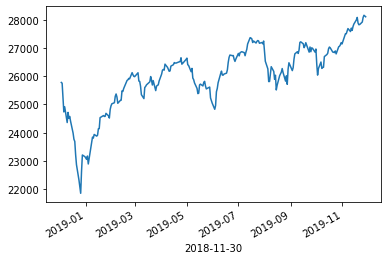

In [21]:
ts.plot()
# критерий Дики-Фуллера
adfuller(ts)[1]

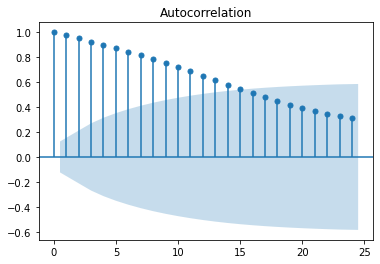

In [22]:
plot_acf(ts);

Дифференцируем один раз ряд, так как он сильно напоминает интегрированный ряд 

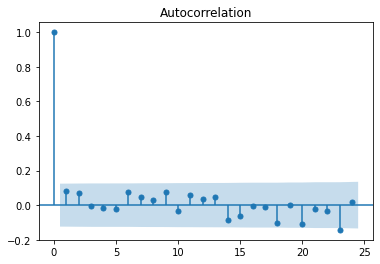

In [23]:
plot_acf(ts.diff().dropna());

In [24]:
# критерий Дики-Фуллера
adfuller(ts.diff().dropna())[1]

7.270680965723897e-27

#### 4. Рассмотрите ряд data/dataset/stl_example.csv. Постройте для него график автокорреляций. Обьясните закономерности, которые вы видите.

In [25]:
ts = dataset['stl_example.csv']

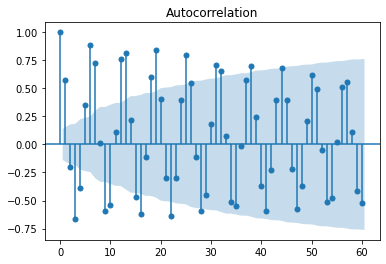

In [28]:
plot_acf(ts, lags=60);

Сильная сезонность с периодом 6 (7). При этом максимальная корреляция медленно убывает с увеличением лага.

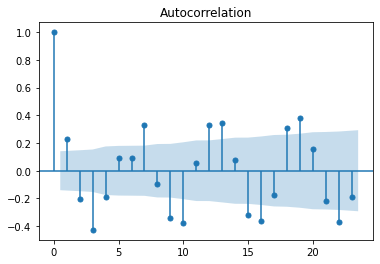

In [30]:
plot_acf(ts.diff(6).dropna());

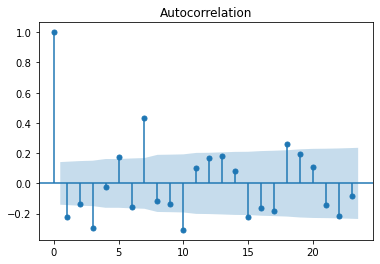

In [32]:
plot_acf(ts.diff().diff(6).dropna());

In [33]:
# критерий Дики-Фуллера
adfuller(ts.diff().diff(6).dropna())[1]

4.728845378199303e-19

 5.На семинаре, посвященном stl разложению мы находили период
сезонности сезонных временных рядов при помощи графика автокорреляций.
Однако, если бы мы захотели построить автоматическую систему определения
периода, мы бы уже не могли “вручную” анализировать каждый график. Таким
образом вам необходимо написать функцию get_seasonal_period(), которая бы
автоматически определяла период сезонных временных рядов, использую
автокорреляционную функцию.

In [56]:
from scipy import signal
from scipy.fft import fft, fftfreq

from statsmodels.tsa.stattools import acf

1.Решим задачу с помощью FFT

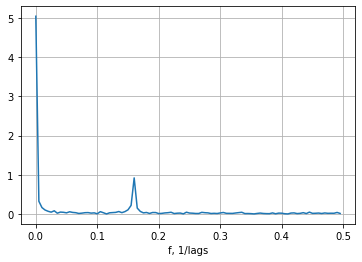

In [127]:
# FFT-transform
ts = dataset['stl_example.csv']

N = len(ts)
x = np.linspace(0.0, N, N, endpoint=False)
y = ts.values
yf = fft(y)
xf = fftfreq(N)[:N//2]

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

plt.xlabel('f, 1/lags')
plt.grid()
plt.show()

In [128]:
def get_seasonal_period_fft(ts):
    
    N = len(ts)
    x = np.linspace(0.0, N, N, endpoint=False)
    y = ts.values
    
    yf = fft(y)
    xf = fftfreq(N)[:N//2]
    
    ind_max_fft = np.argmax(np.abs(yf[1:N//2]))
    
    return np.round(1/xf[ind_max_fft])

In [129]:
print("Период сезонности : {}".format(get_seasonal_period_fft(ts)))

Период сезонности : 6.0


2.Решим задачу с помощью автокорреляции

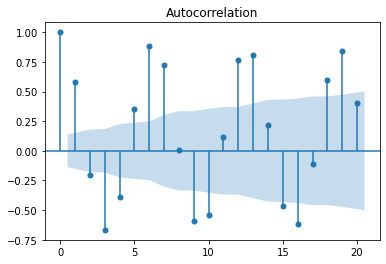

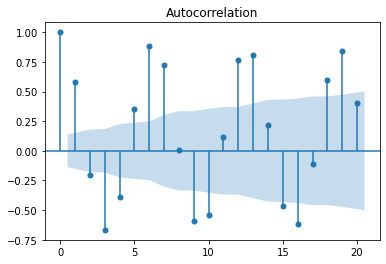

In [130]:
plot_acf(ts, lags=20)

In [131]:
def get_seasonal_period_autocorr(ts, nlags=40, max_period=12):
    """
    max_period - максимальный период сезонности, который мы ищем
    """
    autocorr = acf(ts, nlags)
    
    return np.argmax(autocorr[1:max_period])+1

In [133]:
get_seasonal_period_autocorr(ts)

6

In [134]:
def get_seasonal_k_period_autocorr(ts, k_period):
    """
    k_period - выведем первые k лагов, которые похожи на периоды
    """
    
    autocorr = acf(ts)
    
    return np.argsort(autocorr[:])[-2:-2-k_period:-1]

In [135]:
get_seasonal_k_period_autocorr(ts, k_period=3)

array([ 6, 19, 13], dtype=int64)

В данном случае косвенно можно понять, что период сезонности примерно 6, т.к остальные максимумы ~пропорциональны 6